In [63]:
import numpy
import corner
import emcee
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import scipy.optimize
import sys
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import scipy.optimize as op
from astropy.constants import c
import functions_polarization_MCMC as mcmc
import function_plots as mcmc_plots
from importlib import reload
import time
import tqdm 

import scipy.stats
import math
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

In [80]:
# Importing data:
path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_adapbox_rsl.fits'))[1].data

path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_polint = 'rmsynth_polint_1'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_polint+'.fits'))[0]
del hdu_polint.header['CROTA4']
data_polint = hdu_polint.data
wcs = WCS(hdu_polint.header)

savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

freqs = np.load('MKT_Freqs_mid.npy')

lamb = c.value/freqs

flux_measurements_I = np.load(savedir+'Abell85_BDSF_I.npy')
flux_measurements_Q = np.load(savedir+'Abell85_BDSF_Q.npy')
flux_measurements_U = np.load(savedir+'Abell85_BDSF_U.npy')
flux_unc_I = np.load(savedir+'Abell85_BDSF_unc_I.npy')
flux_unc_Q = np.load(savedir+'Abell85_BDSF_unc_Q.npy')
flux_unc_U = np.load(savedir+'Abell85_BDSF_unc_U.npy')
sources_phi = np.load(savedir+'Abell85_phi.npy')
mask = np.load(r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'+'Abell85_mask_5sigma10pix.npy')

I_select = flux_measurements_I[:,mask]
Q_select = flux_measurements_Q[:,mask]
U_select = flux_measurements_U[:,mask]
I_unc_select = flux_unc_I[:,mask]
Q_unc_select = flux_unc_Q[:,mask]
U_unc_select = flux_unc_U[:,mask]
phi_select = sources_phi[mask]
rsl_select = rsl[mask]

angles_select = 0.5*np.arctan2(U_select, Q_select)
angles_select_err = np.sqrt((Q_select*U_unc_select)**2 + (U_select*Q_unc_select)**2)/(2*(U_select**2 + Q_select**2))
linpol_select = np.sqrt(U_select**2 + Q_select**2)
linpol_select_err = (U_select*U_unc_select + Q_select*Q_unc_select)/linpol_select
p_select = linpol_select/I_select
p_select_err = p_select*np.sqrt((0*linpol_select_err/linpol_select)**2 + (I_unc_select/I_select)**2)

directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
norm_fit = np.load(directory+'Abell85_mcmc_Inorm_free.npy')
spix_fit = np.load(directory+'Abell85_mcmc_Ispix_free.npy')
curv_fit = np.load(directory+'Abell85_mcmc_Icurv_free.npy')
p0_fit = np.load(directory+'Abell85_mcmc_p0_free.npy')
chi0_fit = np.load(directory+'Abell85_mcmc_chi0_free.npy')
RM_fit = np.load(directory+'Abell85_mcmc_RM_free.npy')
sigma_fit = np.load(directory+'Abell85_mcmc_sigma_free.npy')

redchisq_QU_list = np.load(directory+'Abell85_mcmc_QUchisqw_free.npy')
redchisq_I_list = np.load(directory+'Abell85_mcmc_Ichisqw_free.npy')

norm_list = norm_fit[:,0]
spix_list = spix_fit[:,0]
curv_list = curv_fit[:,0]
p0_list = p0_fit[:,0]
chi0_list = chi0_fit[:,0]
RM_list = RM_fit[:,0]
sigma_list = sigma_fit[:,0]

def uncertainty(array):
    return np.mean(np.abs(array[:,1:]), axis=1)

norm_unc_list = uncertainty(norm_fit)
spix_unc_list = uncertainty(spix_fit)
curv_unc_list = uncertainty(curv_fit)
p0_unc_list = uncertainty(p0_fit)
chi0_unc_list = uncertainty(chi0_fit)
RM_unc_list = uncertainty(RM_fit)
sigma_unc_list = uncertainty(sigma_fit)

print(norm_fit[46])
print(p0_fit[46])
print(chi0_fit[46])

[ 0.00531142 -0.00011104  0.00011231]
[ 0.09542671 -0.0095084   0.01011337]
[ 0.90481781 -0.1116449   0.10586952]


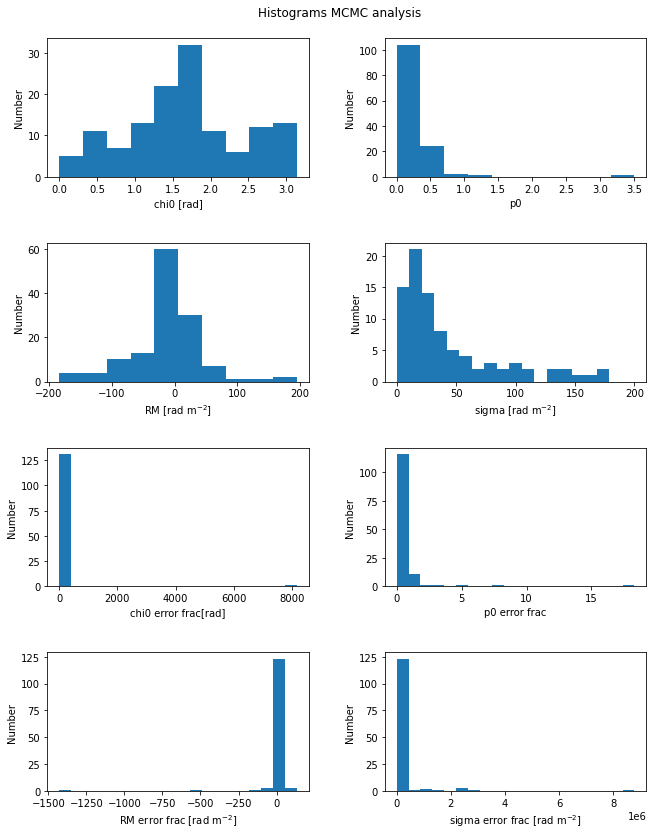

In [81]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 12)
fig.tight_layout(pad=4.5)
fig.suptitle('Histograms MCMC analysis')

axs[0,0].hist(chi0_list)
axs[0,0].set_ylabel('Number')
axs[0,0].set_xlabel('chi0 [rad]')

axs[0,1].hist(p0_list)
axs[0,1].set_ylabel('Number')
axs[0,1].set_xlabel('p0')

axs[1,0].hist(RM_list)
axs[1,0].set_ylabel('Number')
axs[1,0].set_xlabel(r'RM [rad m$^{-2}$]')

axs[1,1].hist(sigma_list, bins=np.linspace(0,200,20))
axs[1,1].set_ylabel('Number')
axs[1,1].set_xlabel(r'sigma [rad m$^{-2}$]')

axs[2,0].hist(chi0_unc_list/chi0_list, bins=20)
axs[2,0].set_ylabel('Number')
axs[2,0].set_xlabel('chi0 error frac[rad]')

axs[2,1].hist(p0_unc_list/p0_list, bins=20)
axs[2,1].set_ylabel('Number')
axs[2,1].set_xlabel('p0 error frac')

axs[3,0].hist(RM_unc_list/RM_list, bins=20)
axs[3,0].set_ylabel('Number')
axs[3,0].set_xlabel(r'RM error frac [rad m$^{-2}$]')

axs[3,1].hist(sigma_unc_list/sigma_list, bins=20)
axs[3,1].set_ylabel('Number')
axs[3,1].set_xlabel(r'sigma error frac [rad m$^{-2}$]')
plt.show()

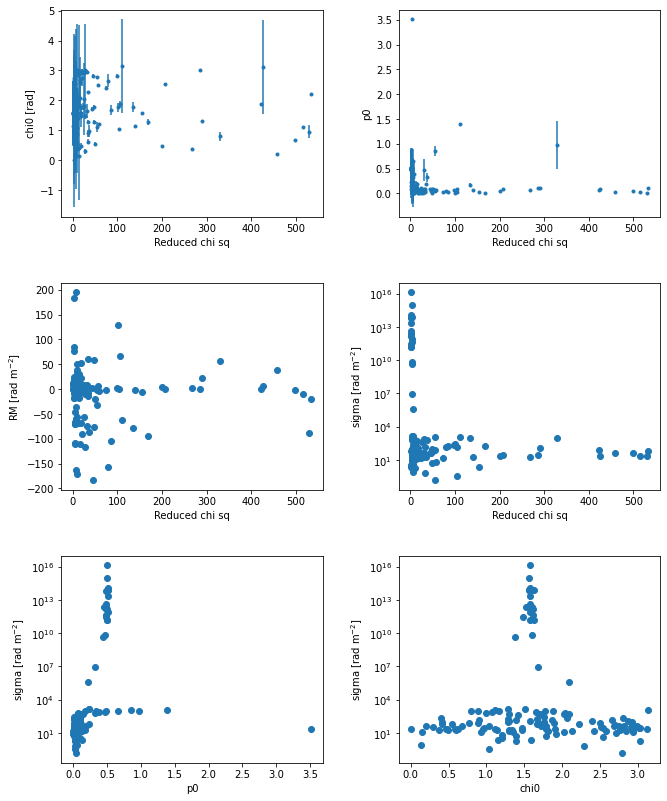

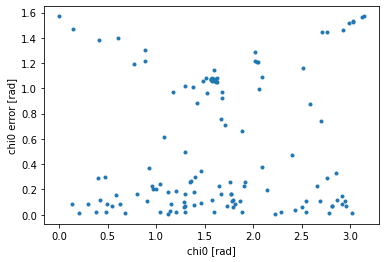

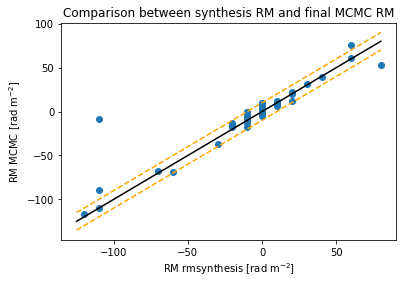

In [320]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 12)
fig.tight_layout(pad=4.5)

axs[0,0].errorbar(redchisq_QU_list, chi0_list, yerr=chi0_unc_list, fmt='.')
axs[0,0].set_xlabel('Reduced chi sq')
axs[0,0].set_ylabel('chi0 [rad]')

axs[0,1].errorbar(redchisq_QU_list, p0_list, yerr=p0_unc_list, fmt='.')
axs[0,1].set_xlabel('Reduced chi sq')
axs[0,1].set_ylabel('p0')

axs[1,0].scatter(redchisq_QU_list, RM_list)
axs[1,0].set_xlabel('Reduced chi sq')
axs[1,0].set_ylabel('RM [rad m$^{-2}$]')

axs[1,1].scatter(redchisq_QU_list, sigma_list)
axs[1,1].set_xlabel('Reduced chi sq')
axs[1,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[1,1].set_yscale('log')

axs[2,0].scatter(p0_list, sigma_list)
axs[2,0].set_xlabel('p0')
axs[2,0].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,0].set_yscale('log')

axs[2,1].scatter(chi0_list, sigma_list)
axs[2,1].set_xlabel('chi0')
axs[2,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,1].set_yscale('log')

plt.show()

plt.errorbar(chi0_list, chi0_unc_list, fmt='.')
plt.xlabel('chi0 [rad]')
plt.ylabel('chi0 error [rad]')
plt.show()

plt.title('Comparison between synthesis RM and final MCMC RM')
plt.scatter(phi_select[mask_inspec], RM_list[mask_inspec])
plt.plot([-125,80],[-125,80],color='black')
plt.plot([-125,80],[-115,90],color='orange', linestyle='dashed')
plt.plot([-125,80],[-135,70],color='orange', linestyle='dashed')
plt.xlabel('RM rmsynthesis [rad m$^{-2}$]')
plt.ylabel('RM MCMC [rad m$^{-2}$]')
plt.show()

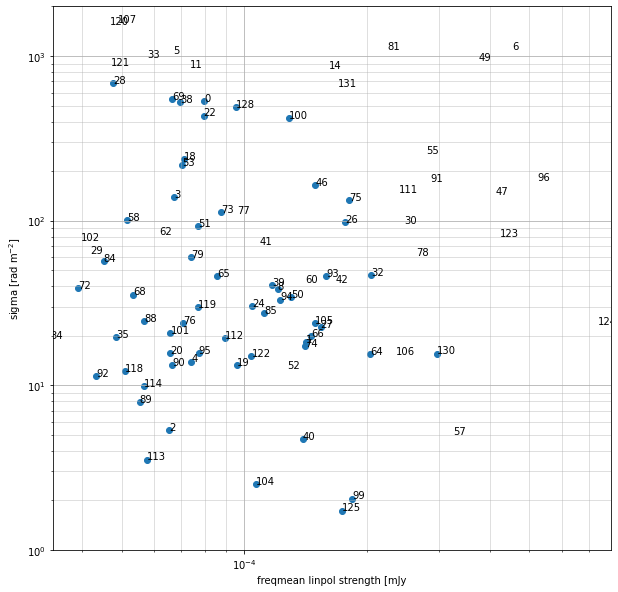

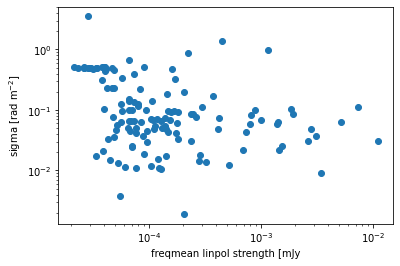

In [214]:
plt.figure(figsize=(10,10))
plt.scatter(np.mean(linpol_select, axis=0)[mask_inspec], sigma_list[mask_inspec])
for n in range(len(sigma_list)):
    plt.text(np.mean(linpol_select, axis=0)[n], sigma_list[n], str(n), clip_on=True)
plt.grid(alpha=1)
plt.grid(alpha=0.5, which='minor')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e0, 2e3)
plt.ylabel('sigma [rad m$^{-2}$]')
plt.xlabel('freqmean linpol strength [mJy')
plt.show()

plt.scatter(np.mean(linpol_select, axis=0), p0_list)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('sigma [rad m$^{-2}$]')
plt.xlabel('freqmean linpol strength [mJy')
plt.show()

# Flagging:

In [327]:
sigma = 5
conf_int = scipy.stats.chi2.cdf(sigma**2,1)
red_chi_lim = scipy.stats.chi2.ppf(conf_int, 20)/20
print('reduced chisqw at 5 sigma is: ' + str(red_chi_lim))

mask_inspec = np.argwhere((sigma_list<200)&((sigma_unc_list/sigma_list)<2)&(RM_unc_list/RM_list<2)&(p0_list<0.2)&(redchisq_QU_list < 40))
#np.argwhere((sigma_list<200)&(redchisq_QU_list < 100))#&(chi0_list<0.02))\
                          #&(p0_list<0.5)&(sigma_unc_list/sigma_list< 1)&(np.abs(RM_unc_list/RM_list< 1))\
                          #&(p0_unc_list/p0_list< 1)&(chi0_unc_list/chi0_list< 1))[:,0]
mask_inspec = mask_inspec[:,0]
print(np.shape(mask_inspec))

print(mask_inspec)
sigma_list[7]

reduced chisqw at 5 sigma is: 3.346399525618504
(49,)
[  1   2   3   8  19  20  24  26  27  32  35  39  40  46  50  51  58  64
  65  66  68  72  73  74  75  76  79  85  87  88  89  90  92  93  94  95
  99 101 104 105 112 113 114 117 118 119 122 125 130]


9218089.442739664

112
Chi0, p0, RM, sigma, redchisqw
2.764445063725267 0.018807692499525096 -89.90304768606833 19.40636881913708 21.423838712846386
Relative errors
0.10535307464654199 0.27615234204329986 -0.03493443690610273 1.0605799607857747


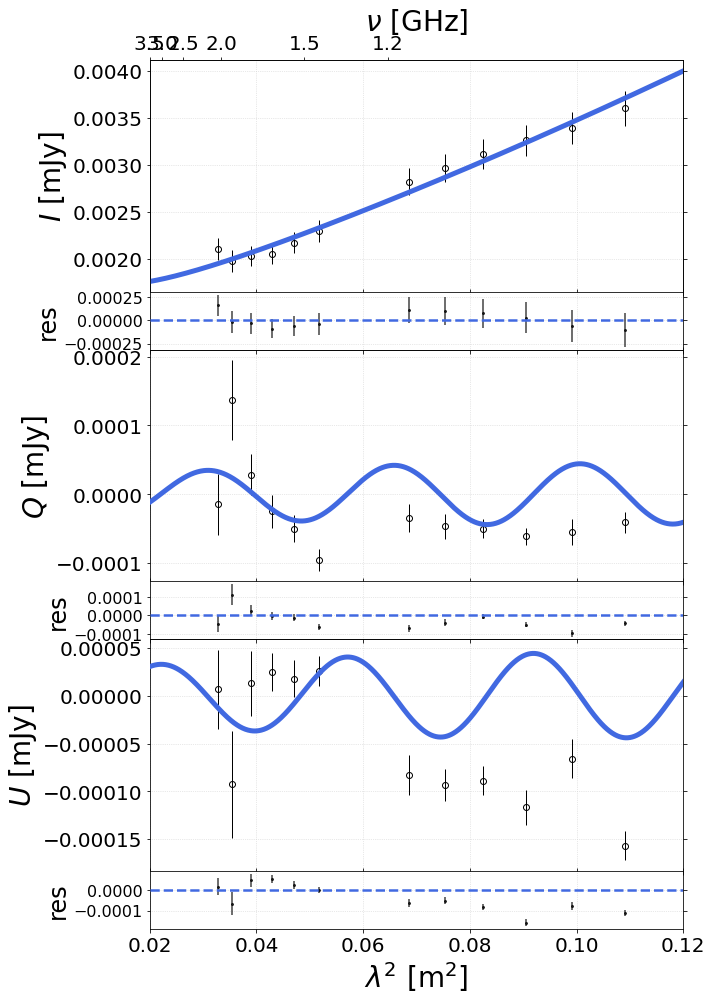

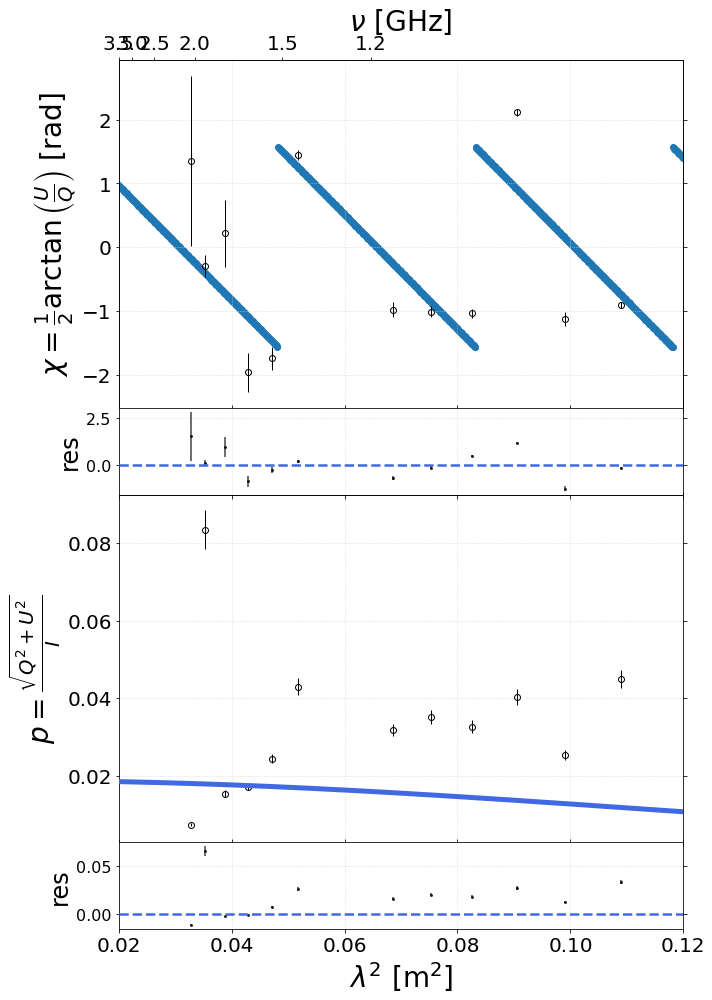

In [328]:
number = 112
print(number)
print('Chi0, p0, RM, sigma, redchisqw')
print(chi0_list[number], p0_list[number], RM_list[number], sigma_list[number], redchisq_QU_list[number])
print('Relative errors')
print(chi0_unc_list[number]/chi0_list[number], p0_unc_list[number]/p0_list[number], RM_unc_list[number]/RM_list[number], sigma_unc_list[number]/sigma_list[number])

mcmc_plots.plots('ExtDepol', 'depolfit_test', lamb**2, norm_list[number], spix_list[number], curv_list[number]\
            , p0_list[number], chi0_list[number], RM_list[number], np.sqrt(sigma_list[number]), I_select[:,number]\
            , I_unc_select[:,number], Q_select[:,number], Q_unc_select[:,number], U_select[:,number], U_unc_select[:,number]\
            , angles_select[:,number], angles_select_err[:,number], p_select[:,number]\
            , p_select_err[:,number], xlim=[0.02, 0.12], imgformat="pdf",saveplot=False)

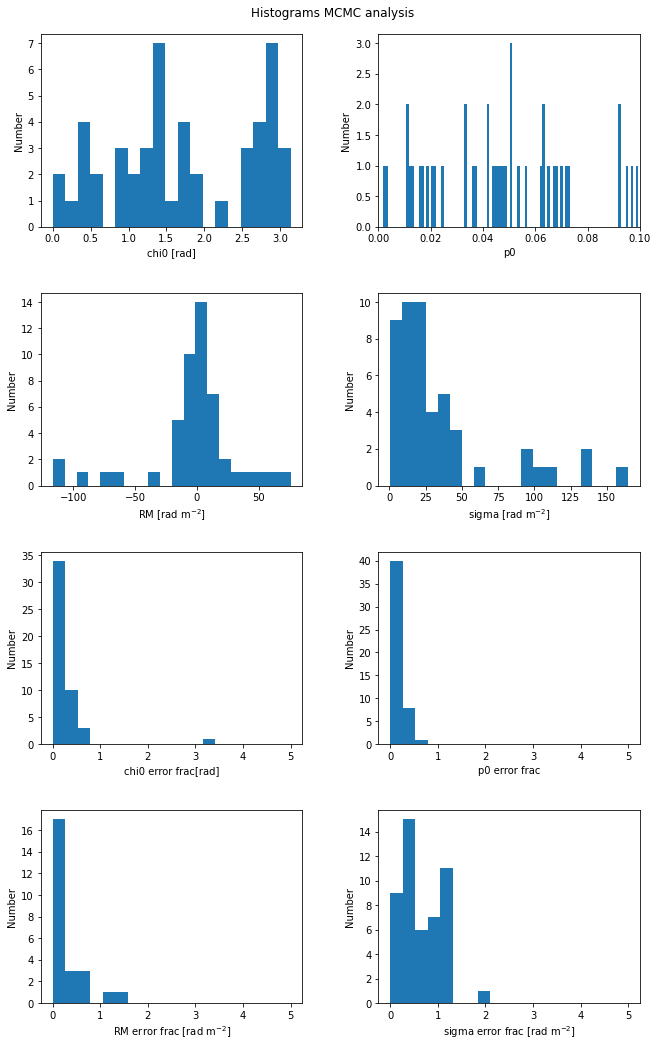

In [329]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

fig.suptitle('Histograms MCMC analysis')

axs[0,0].hist(chi0_list[mask_inspec], bins=np.linspace(0,np.pi,20))
axs[0,0].set_ylabel('Number')
axs[0,0].set_xlabel('chi0 [rad]')

axs[0,1].hist(p0_list[mask_inspec], bins=200)
axs[0,1].set_ylabel('Number')
axs[0,1].set_xlim(0,0.1)
axs[0,1].set_xlabel('p0')

axs[1,0].hist(RM_list[mask_inspec], bins=20)
axs[1,0].set_ylabel('Number')
axs[1,0].set_xlabel(r'RM [rad m$^{-2}$]')

axs[1,1].hist(sigma_list[mask_inspec], bins=20)#, bins=np.linspace(0,200,20))
axs[1,1].set_ylabel('Number')
axs[1,1].set_xlabel(r'sigma [rad m$^{-2}$]')

axs[2,0].hist(chi0_unc_list[mask_inspec]/chi0_list[mask_inspec], bins=np.linspace(0,5,20))
axs[2,0].set_ylabel('Number')
axs[2,0].set_xlabel('chi0 error frac[rad]')

axs[2,1].hist(p0_unc_list[mask_inspec]/p0_list[mask_inspec], bins=np.linspace(0,5,20))
axs[2,1].set_ylabel('Number')
axs[2,1].set_xlabel('p0 error frac')

axs[3,0].hist(RM_unc_list[mask_inspec]/RM_list[mask_inspec], bins=np.linspace(0,5,20))
axs[3,0].set_ylabel('Number')
axs[3,0].set_xlabel(r'RM error frac [rad m$^{-2}$]')

axs[3,1].hist(sigma_unc_list[mask_inspec]/sigma_list[mask_inspec], bins=np.linspace(0,5,20))
axs[3,1].set_ylabel('Number')
axs[3,1].set_xlabel(r'sigma error frac [rad m$^{-2}$]')
plt.show()

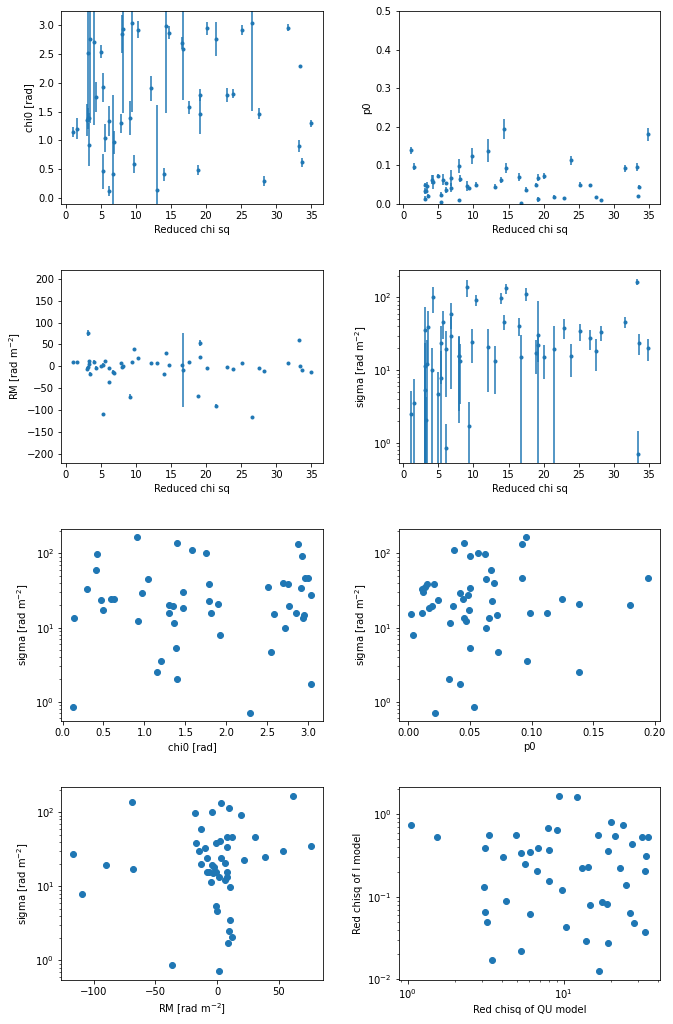

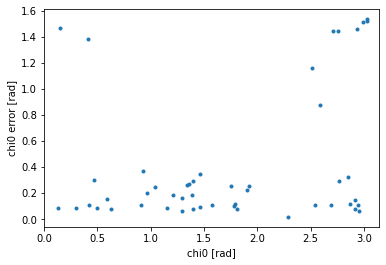

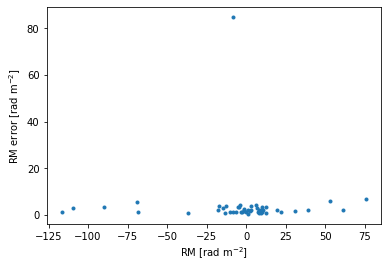

In [330]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

axs[0,0].errorbar(redchisq_QU_list[mask_inspec], chi0_list[mask_inspec]\
                  , yerr=chi0_unc_list[mask_inspec], fmt='.')
axs[0,0].set_xlabel('Reduced chi sq')
axs[0,0].set_ylabel('chi0 [rad]')
axs[0,0].set_ylim(-0.1,np.pi+0.1)

axs[0,1].errorbar(redchisq_QU_list[mask_inspec], p0_list[mask_inspec]\
                  , yerr=p0_unc_list[mask_inspec], fmt='.')
axs[0,1].set_xlabel('Reduced chi sq')
axs[0,1].set_ylabel('p0')
axs[0,1].set_ylim(0,0.5)

axs[1,0].errorbar(redchisq_QU_list[mask_inspec], RM_list[mask_inspec]\
                  , yerr=RM_unc_list[mask_inspec], fmt='.')
axs[1,0].set_xlabel('Reduced chi sq')
axs[1,0].set_ylabel('RM [rad m$^{-2}$]')
axs[1,0].set_ylim(-220,220)

axs[1,1].errorbar(redchisq_QU_list[mask_inspec], sigma_list[mask_inspec]\
                , yerr=sigma_unc_list[mask_inspec], fmt='.')
axs[1,1].set_xlabel('Reduced chi sq')
axs[1,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[1,1].set_yscale('log')

axs[2,0].scatter(chi0_list[mask_inspec], sigma_list[mask_inspec])
axs[2,0].set_xlabel('chi0 [rad]')
axs[2,0].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,0].set_yscale('log')

axs[2,1].scatter(p0_list[mask_inspec], sigma_list[mask_inspec])
axs[2,1].set_xlabel('p0')
axs[2,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,1].set_yscale('log')

axs[3,0].scatter(RM_list[mask_inspec], sigma_list[mask_inspec])
axs[3,0].set_xlabel('RM [rad m$^{-2}$]')
axs[3,0].set_ylabel('sigma [rad m$^{-2}$]')
axs[3,0].set_yscale('log')

axs[3,1].scatter(redchisq_QU_list[mask_inspec], redchisq_I_list[mask_inspec])
axs[3,1].set_xlabel('Red chisq of QU model')
axs[3,1].set_ylabel('Red chisq of I model')
axs[3,1].set_xscale('log')
axs[3,1].set_yscale('log')

plt.show()

plt.errorbar(chi0_list[mask_inspec], chi0_unc_list[mask_inspec], fmt='.')
plt.xlabel('chi0 [rad]')
plt.ylabel('chi0 error [rad]')
plt.xlim(0,np.pi)
plt.show()

plt.errorbar(RM_list[mask_inspec], RM_unc_list[mask_inspec], fmt='.')
plt.xlabel('RM [rad m$^{-2}$]')
plt.ylabel('RM error [rad m$^{-2}$]')
plt.show()

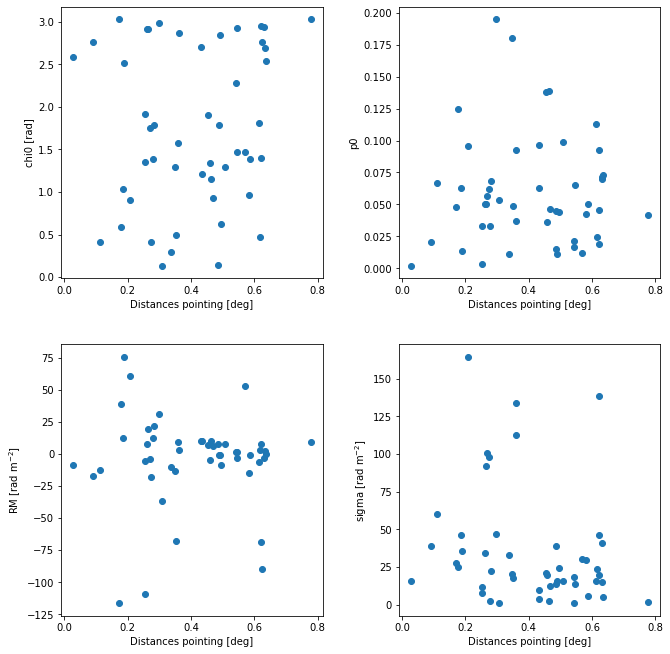

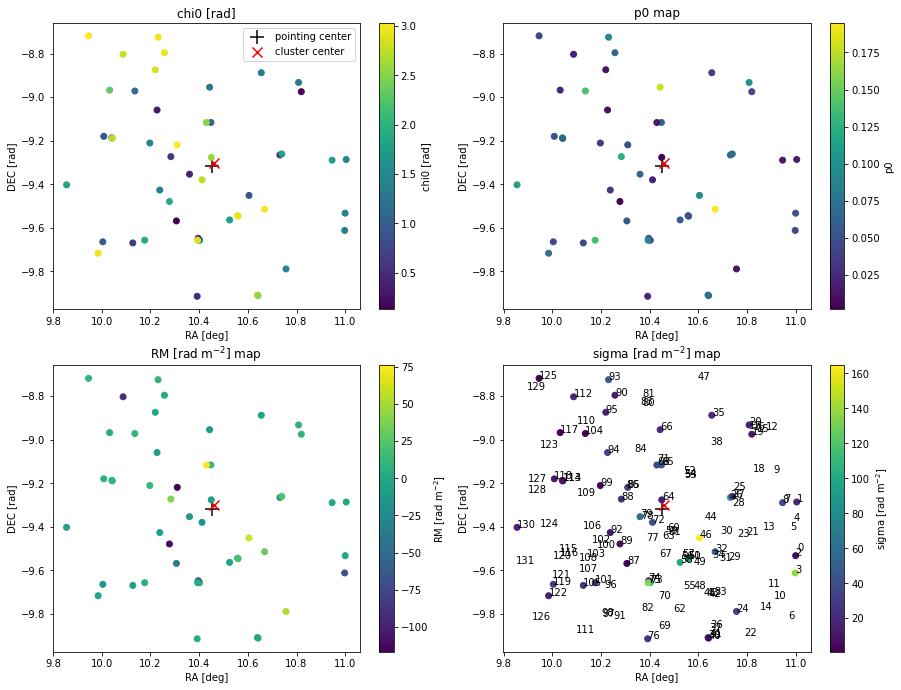

In [331]:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)

wcs_new = wcs.celestial

loc_world_selected = wcs_new.pixel_to_world(sources_pixpos[mask,0], sources_pixpos[mask,1]).data
point_center = wcs_new.pixel_to_world(3617/2, 3617/2)

cluster_ra = Angle('0:41:50.390 hours')
cluster_dec = Angle('-9:18:09.53 degrees')
cluster_center = SkyCoord(ra=cluster_ra, dec=cluster_dec, frame='icrs')
cluster_center_pixpos = wcs.all_world2pix(cluster_ra, cluster_dec, 0)

#print(point_center)
#print(cluster_center)

distances_pointing = np.sqrt((loc_world_selected.lon.degree-point_center.data.lon.degree)**2+(loc_world_selected.lat.degree-point_center.data.lat.degree)**2) #This is an approximation
distances_cluster = np.sqrt((loc_world_selected.lon.degree-cluster_center.data.lon.degree)**2+(loc_world_selected.lat.degree-cluster_center.data.lat.degree)**2) #This is an approximation

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.tight_layout(pad=4.5)

axs[0,0].scatter(distances_cluster[mask_inspec], chi0_list[mask_inspec])
axs[0,0].set_xlabel('Distances pointing [deg]')
axs[0,0].set_ylabel('chi0 [rad]')

axs[0,1].scatter(distances_cluster[mask_inspec], p0_list[mask_inspec])
axs[0,1].set_xlabel('Distances pointing [deg]')
axs[0,1].set_ylabel('p0')

axs[1,0].scatter(distances_cluster[mask_inspec], RM_list[mask_inspec])
#for n in range(len(distances_cluster)):
#    axs[1,0].text(distances_cluster[n], RM_list[n], str(n), clip_on=True)
axs[1,0].set_xlabel('Distances pointing [deg]')
axs[1,0].set_ylabel('RM [rad m$^{-2}$]')

axs[1,1].scatter(distances_cluster[mask_inspec], sigma_list[mask_inspec])
#for n in range(len(distances_cluster)):
#    axs[1,1].text(distances_cluster[n], sigma_list[n], str(n), clip_on=True)
axs[1,1].set_xlabel('Distances pointing [deg]')
axs[1,1].set_ylabel('sigma [rad m$^{-2}$]')

plt.show()


fig, axs = plt.subplots(2, 2)
fig.set_size_inches(13,10)
fig.tight_layout(pad=3.5)

axs[0,0].set_title('chi0 [rad]')
img1 = axs[0,0].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=chi0_list[mask_inspec], zorder=2)
axs[0,0].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black'\
                 , marker='+', s=2e2, label='pointing center')
axs[0,0].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red'\
                 , marker='x', s=1e2, label='cluster center')
axs[0,0].set_xlabel('RA [deg]')
axs[0,0].set_ylabel('DEC [rad]')
axs[0,0].legend()
plt.colorbar(img1, ax=axs[0,0], orientation='vertical', label='chi0 [rad]')

axs[0,1].set_title('p0 map')
img2 = axs[0,1].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=p0_list[mask_inspec], zorder=2)
axs[0,1].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black'\
                 , marker='+', s=2e2)
axs[0,1].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red'\
                 , marker='x', s=1e2)
axs[0,1].set_xlabel('RA [deg]')
axs[0,1].set_ylabel('DEC [rad]')
plt.colorbar(img2, ax=axs[0,1], orientation='vertical', label='p0')

axs[1,0].set_title('RM [rad m$^{-2}$] map')
img3 = axs[1,0].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=RM_list[mask_inspec], zorder=2)
axs[1,0].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black', marker='+', s=2e2)
axs[1,0].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red', marker='x', s=1e2)
axs[1,0].set_xlabel('RA [deg]')
axs[1,0].set_ylabel('DEC [rad]')
plt.colorbar(img3, ax=axs[1,0], orientation='vertical', label='RM [rad m$^{-2}$]')

axs[1,1].set_title('sigma [rad m$^{-2}$] map')
img4 = axs[1,1].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=sigma_list[mask_inspec], zorder=2)
for n in range(len(distances_cluster)):
    axs[1,1].text(loc_world_selected.lon.degree[n], loc_world_selected.lat.degree[n], str(n), clip_on=True)
axs[1,1].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black', marker='+', s=2e2)
axs[1,1].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red', marker='x', s=1e2)
axs[1,1].set_xlabel('RA [deg]')
axs[1,1].set_ylabel('DEC [rad]')
plt.colorbar(img4, ax=axs[1,1], orientation='vertical', label='sigma [rad m$^{-2}$]')

plt.show()

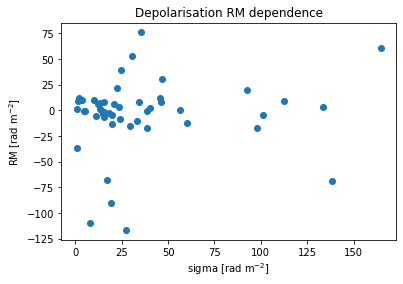

In [326]:
plt.title('Depolarisation RM dependence')
plt.scatter(sigma_list[mask_inspec], RM_list[mask_inspec])
plt.xlabel('sigma [rad m$^{-2}$]')
plt.ylabel('RM [rad m$^{-2}$]')
plt.show()

# Fit visualisation:

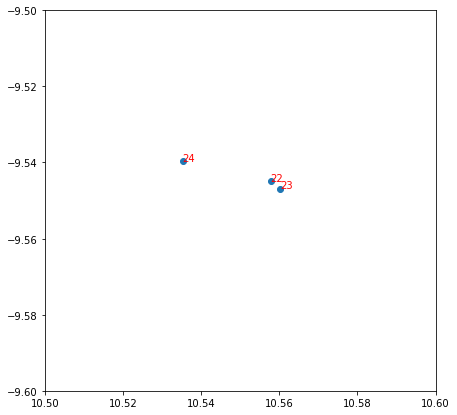

In [141]:
#Check at which source we are looking:

plt.figure(figsize=(7,7))
plt.scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec])
for n in range(len(loc_world_selected.lon.degree[mask_inspec])):
    plt.text(loc_world_selected.lon.degree[mask_inspec][n], loc_world_selected.lat.degree[mask_inspec][n], str(n), color='red', clip_on=True)

plt.xlim(10.5,10.6)
plt.ylim(-9.6,-9.5)
plt.show()

# Calculate p_1.5Ghz

In [142]:
x15 = (c.value/1.5e9)**2
p15 = np.zeros(len(norm_list))

for n in range(len(norm_list)):
    _,_,p15[n],_ = models(x15, p0_list[n, 0], chi0_list[n, 0], RM_list[n, 0], sigma_list[n, 0], norm_list[n, 0], spix_list[n, 0], curv_list[n, 0])

depol_rat = p15/p0_list[:,0]
depol_rat_data = p_select[6,:]/p0_list[:,0]

NameError: name 'models' is not defined

In [ ]:
plt.figure(figsize=(10,8))
plt.title('depolarisation vs distance from cluster center')
plt.scatter(distances_cluster[mask_inspec], depol_rat_data[mask_inspec])
#plt.scatter(distances_cluster[mask_inspec], depol_rat[mask_inspec])
plt.xlabel('Distances pointing [deg]')
plt.ylabel('depolarisation fraction ($Linpol_{1.51\mathrm{GHz}}$/$p_{0\mathrm{GHz}}$)')
plt.show()